In [1]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
from collections import Counter
from sklearn.utils import resample
import torch.nn.functional as F

/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def crop_center(img):
    y, x = img.shape[0:2]  # Get the original dimensions of the image
    
    startx = x // 2 - 10
    starty = y // 2 - 10
    
    return img[starty:starty + 21, startx:startx + 21]

In [3]:
# Load the TXT file
labels_df = pd.read_csv('data/0ADD710_gated_full_final.txt', sep='\t')
print("Original data shape:", labels_df.shape)

# Filter DataFrame to include only T-cells, B-cells, NK-cells
labels_df = labels_df[labels_df['Multiclass_5'].isin(['T-cells', 'B-cells', 'NK-cells'])]

# Analyze class distribution for the three classes
class_counts = Counter(labels_df['Multiclass_5'])
print("Class distribution after filtering:", class_counts)

# Determine the smallest class size for balancing
min_class_size = min(class_counts.values())

# Balance the dataset by sampling each class to the size of the smallest class
balanced_df = pd.DataFrame()  # Empty DataFrame to hold balanced data
for class_label in ['T-cells', 'B-cells', 'NK-cells']:
    class_subset = labels_df[labels_df['Multiclass_5'] == class_label]
    resampled_subset = resample(class_subset, 
                                replace=False,  # No need to replace as we are downsampling to the smallest class size
                                n_samples=min_class_size, 
                                random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

balanced_df = balanced_df.sample(frac=1, random_state=42)  # Shuffle the dataset

# Map string labels to integers for the three classes
label_mapping = {'T-cells': 0, 'B-cells': 1, 'NK-cells': 2}
labels_int = balanced_df['Multiclass_5'].map(label_mapping).values
print("Balanced labels shape:", labels_int.shape)

# Open the HDF5 file
with h5py.File('data/0ADD710_gated_full_lymph.hdf5', 'a') as hdf5_file:
    original_images = hdf5_file['images']
    
    # Assume crop_center function is defined and required
    new_shape = (len(balanced_df), 21, 21) + original_images.shape[3:]
    
    # Update or create 'cropped_images' dataset
    if 'cropped_images' in hdf5_file.keys():
        del hdf5_file['cropped_images']
    cropped_images = hdf5_file.create_dataset('cropped_images', shape=new_shape, dtype=original_images.dtype)
    
    for new_idx, (orig_idx, _) in enumerate(balanced_df.iterrows()):
        orig_img = original_images[orig_idx]
        cropped_img = crop_center(np.array(orig_img))
        cropped_images[new_idx] = cropped_img
    
    # Update or create 'targets' dataset with balanced labels
    if 'cropped_targets' in hdf5_file.keys():
        del hdf5_file['cropped_targets']
    hdf5_file.create_dataset('cropped_targets', data=labels_int)

print("All labels and cropped images appended to HDF5 file successfully.")


Original data shape: (29028, 93)
Class distribution after filtering: Counter({'T-cells': 7068, 'B-cells': 2639, 'NK-cells': 252})
Balanced labels shape: (756,)
All labels and cropped images appended to HDF5 file successfully.


In [16]:
# set parameters
torch.manual_seed(42)

file_path = 'data/0ADD710_gated_full_lymph.hdf5'
# file_path = '0B11619_10x.hdf5'
data_split = (0.7, 0.15, 0.15)
batch_size = 256
learning_rate = 0.002
weight_decay = 0.0005
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cpu


In [17]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        # Open the HDF5 file
        self.hdf5_file = h5py.File(file_path, 'r')

        # Get the number of samples in the dataset
        self.num_samples = len(self.hdf5_file['cropped_images'])

    def permute(self, image):
        if len(image.shape) == 3:
            return image.permute(2, 0, 1)
        else:
            return image.permute(0, 3, 1, 2)

    def __getitem__(self, index):
        # Get the image and target from the HDF5 file
        
        image = self.hdf5_file['cropped_images'][index, :, :, [0, 2]] / 65535.0
        target = self.hdf5_file['cropped_targets'][index]

        # Convert the image and target to PyTorch tensors
        image = self.permute(torch.from_numpy(image).float())
        target = torch.tensor(target, dtype=torch.long)  # Ensure target is a long tensor for CrossEntropyLoss

        # Apply any data augmentations or transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.num_samples

# Define deep neural network model
class MultiClassClassificationModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(MultiClassClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)

        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        return F.log_softmax(x, dim=1)  # Use log softmax for a stable output of probabilities



In [24]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs):
    all_train_loss = []
    all_train_accu = []
    all_val_loss = []
    all_val_accu = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accu = 0.0
        for inputs, targets in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_accu += calc_accuracy(outputs, targets)
        train_loss /= len(train_loader.dataset)
        train_accu /= len(train_loader)
        all_train_loss.append(train_loss)
        all_train_accu.append(train_accu)
        model.eval()
        val_loss = 0.0
        val_accu = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_accu += calc_accuracy(outputs, targets)
        val_loss /= len(val_loader.dataset)
        val_accu /= len(val_loader)
        all_val_loss.append(val_loss)
        all_val_accu.append(val_accu)
        print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}, Train Accu: {:.6f}, Val Accu: {:.6f}'
              .format(epoch + 1, num_epochs, train_loss, val_loss, train_accu, val_accu))
        scheduler.step(val_loss)
    return all_train_loss, all_val_loss, all_train_accu, all_val_accu

def test(model, test_loader):
    model.eval()
    test_pred = []
    test_target = []
    test_images = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            test_images.extend(inputs.cpu().detach().numpy())
            test_pred.extend(outputs.cpu().detach().numpy())
            test_target.extend(targets.cpu().detach().numpy())
    return np.array(test_pred), np.array(test_target), np.concatenate(test_images, axis=0)


def calc_accuracy(pred, target):
    # pred are logits and target are class indices
    pred_labels = pred.argmax(axis=1)  # Get the index of the max log-probability for multi-class
    correct = (pred_labels == target).sum()
    return correct / len(pred)

In [19]:
def calculate_mean_std(loader):
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for images, _ in loader:
        # Assuming images are in shape (batch_size, channels, height, width)
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Using the data loader to calculate mean and std
loader = DataLoader(HDF5Dataset(file_path), batch_size=10, shuffle=False)
mean_values, std_values = calculate_mean_std(loader)
print(f"Calculated mean: {mean_values}")
print(f"Calculated std: {std_values}")

rotation_range = (-85, 85)  # Desired rotation angles

# Define transformations for the training data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(rotation_range),  # Rotation with a range
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=mean_values, std=std_values)  # Normalize images
])

# Transformations for the validation and test sets should not contain any augmentation.
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

Calculated mean: tensor([0.0472, 0.0530])
Calculated std: tensor([0.0910, 0.0756])


In [20]:
# Setup the training phase
model = MultiClassClassificationModel(dropout_rate=0.1)  
model.to(device)
criterion = nn.CrossEntropyLoss()  # cross entropy loss for multi-class
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.3, verbose=True)

# Creating dataset instances with specific transformations
train_dataset = HDF5Dataset(file_path, transform=train_transforms)
val_dataset = HDF5Dataset(file_path, transform=test_transforms)
test_dataset = HDF5Dataset(file_path, transform=test_transforms)

# Determine sizes for each dataset split
dataset_size = len(train_dataset)  # Assuming train_dataset can measure the total dataset size
train_size = int(data_split[0] * dataset_size)
val_size = int(data_split[1] * dataset_size)
test_size = dataset_size - train_size - val_size

# Generate indices and split them
indices = torch.randperm(dataset_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create data subsets for each split
train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)
test_set = Subset(test_dataset, test_indices)

# Create DataLoader objects for each dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [21]:
train_loss, val_loss, train_accu, val_accu = train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs)

Epoch [1/120], Train Loss: 1.166307, Val Loss: 1.099046, Train Accu: 0.392616, Val Accu: 0.353982
Epoch [2/120], Train Loss: 1.136624, Val Loss: 1.047796, Train Accu: 0.473499, Val Accu: 0.398230
Epoch [3/120], Train Loss: 1.032587, Val Loss: 1.083299, Train Accu: 0.456265, Val Accu: 0.389381
Epoch [4/120], Train Loss: 1.011218, Val Loss: 1.036194, Train Accu: 0.487669, Val Accu: 0.398230
Epoch [5/120], Train Loss: 0.961793, Val Loss: 1.042135, Train Accu: 0.525506, Val Accu: 0.451327
Epoch [6/120], Train Loss: 0.982665, Val Loss: 1.000008, Train Accu: 0.469210, Val Accu: 0.530973
Epoch [7/120], Train Loss: 1.000621, Val Loss: 1.097554, Train Accu: 0.570006, Val Accu: 0.451327
Epoch [8/120], Train Loss: 0.978159, Val Loss: 1.013054, Train Accu: 0.484911, Val Accu: 0.486726
Epoch [9/120], Train Loss: 0.918951, Val Loss: 1.001718, Train Accu: 0.542279, Val Accu: 0.548673
Epoch [10/120], Train Loss: 0.904695, Val Loss: 1.121538, Train Accu: 0.585401, Val Accu: 0.530973
Epoch [11/120], Tra

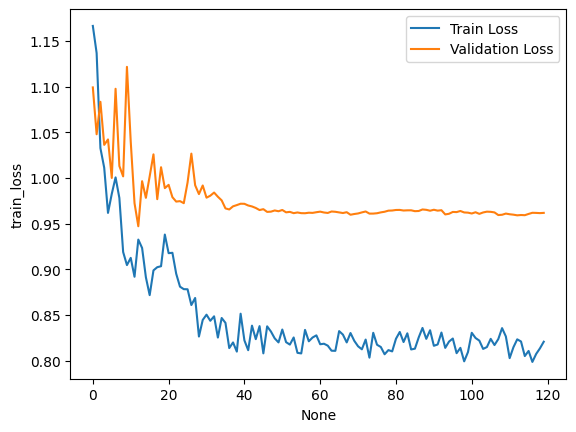

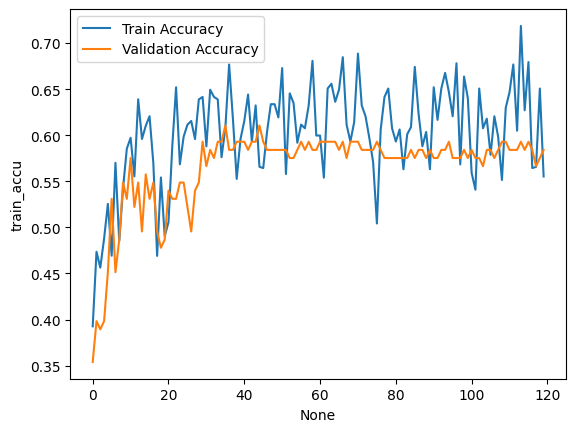

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot the training and validation losses
train_perf = pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss})
sns.lineplot(data=train_perf, y='train_loss', x=train_perf.index, label='Train Loss')
sns.lineplot(data=train_perf, y='val_loss', x=train_perf.index, label='Validation Loss')
plt.show()

# Plot the training and validation accuracies
plt.figure()
train_perf = pd.DataFrame({'train_accu': train_accu, 'val_accu': val_accu})
sns.lineplot(data=train_perf, y='train_accu', x=train_perf.index, label='Train Accuracy')
sns.lineplot(data=train_perf, y='val_accu', x=train_perf.index, label='Validation Accuracy')
plt.show()

Test Accuracy: 0.6140350877192983


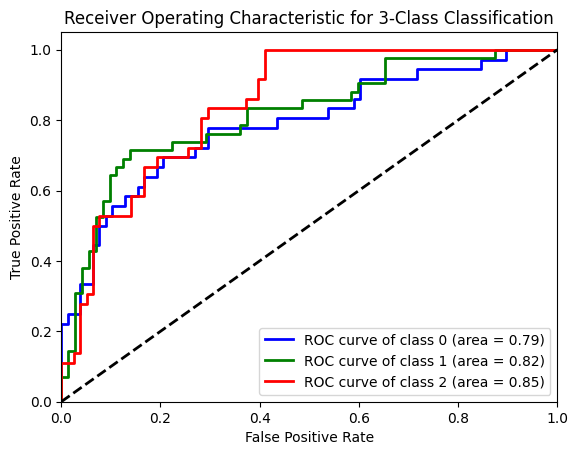

In [26]:
test_pred, test_target, test_image = test(model, test_loader)
print(f"Test Accuracy: {calc_accuracy(test_pred, test_target)}")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the labels for multi-class ROC analysis
n_classes = 3  # Adjusted for 3 classes
test_target_binarized = label_binarize(test_target, classes=np.arange(n_classes))

# Calculate probabilities if your model outputs logits (if model outputs softmax, skip this)
test_pred_probs = np.exp(test_pred) / np.sum(np.exp(test_pred), axis=1, keepdims=True)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_target_binarized[:, i], test_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])  # Adjust color cycle for 3 classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for 3-Class Classification')
plt.legend(loc="lower right")
plt.show()


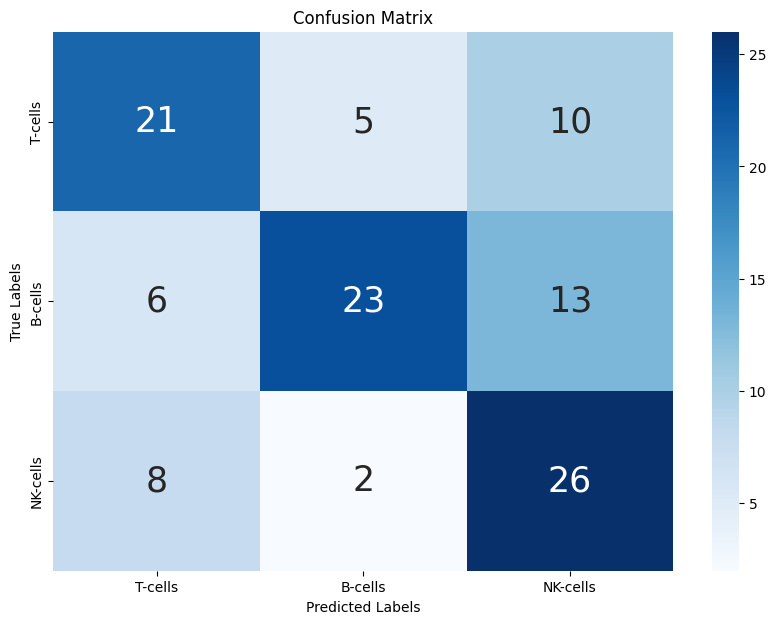

In [36]:
from sklearn.metrics import confusion_matrix

# Assuming test_pred are logits, convert them to predicted class indices
pred_labels = np.argmax(test_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_target, pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 25}, xticklabels=['T-cells', 'B-cells', 'NK-cells'], yticklabels=['T-cells', 'B-cells', 'NK-cells'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
import random

def visualize_image_gallery(images, rows, cols):
    
    if len(images) < rows * cols:
        empty_images = np.repeat(np.zeros_like(images[0])[np.newaxis,...], len(images - rows * cols), axis=0)
        images = np.concatenate((images, empty_images), axis=0)
        
    elif len(images) > rows * cols:
        images = images[random.sample(range(len(images)), rows * cols)]

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=1, hspace=1)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

(228, 21, 21)


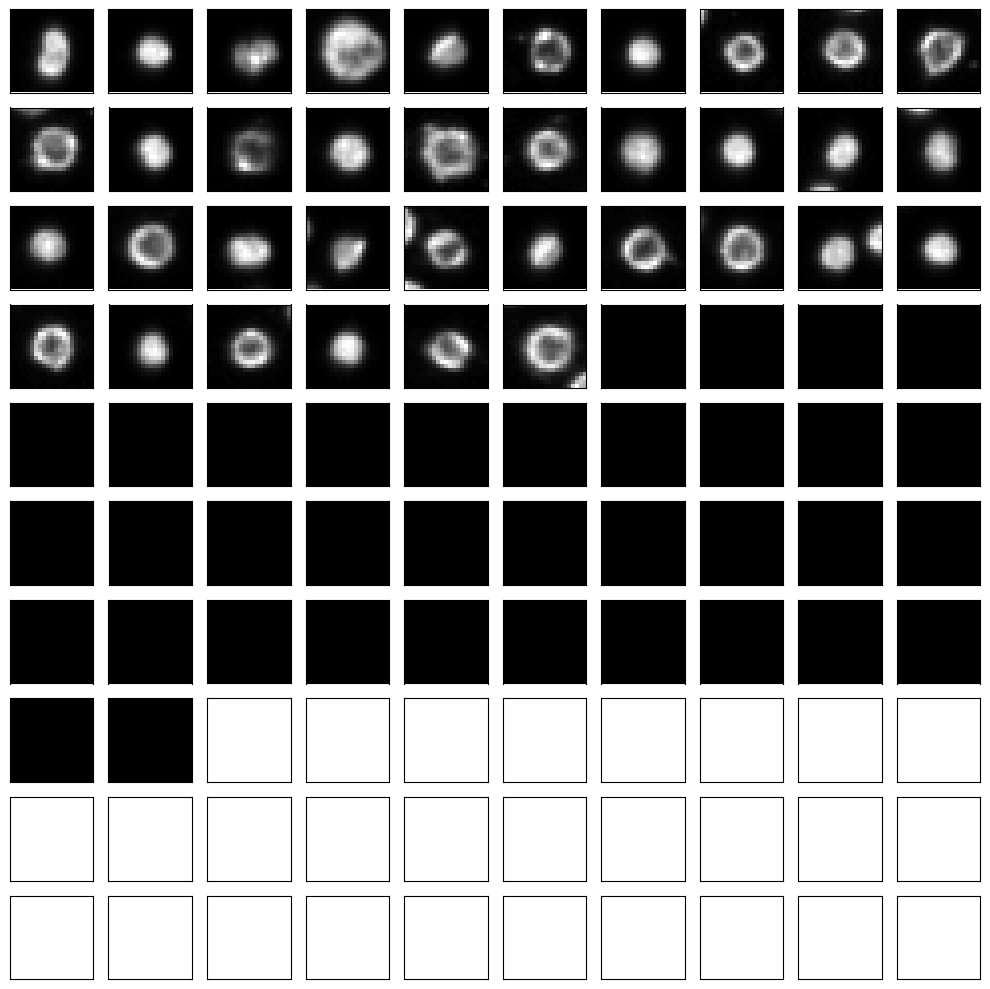

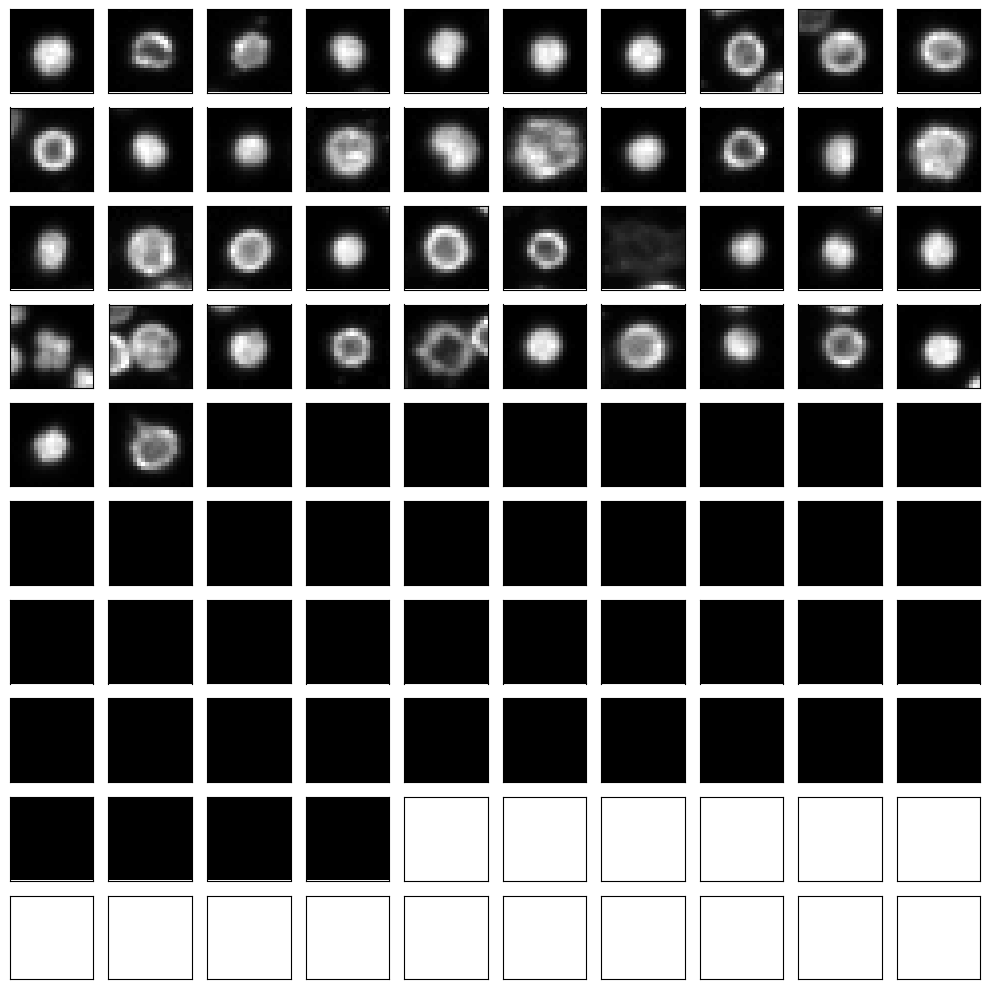

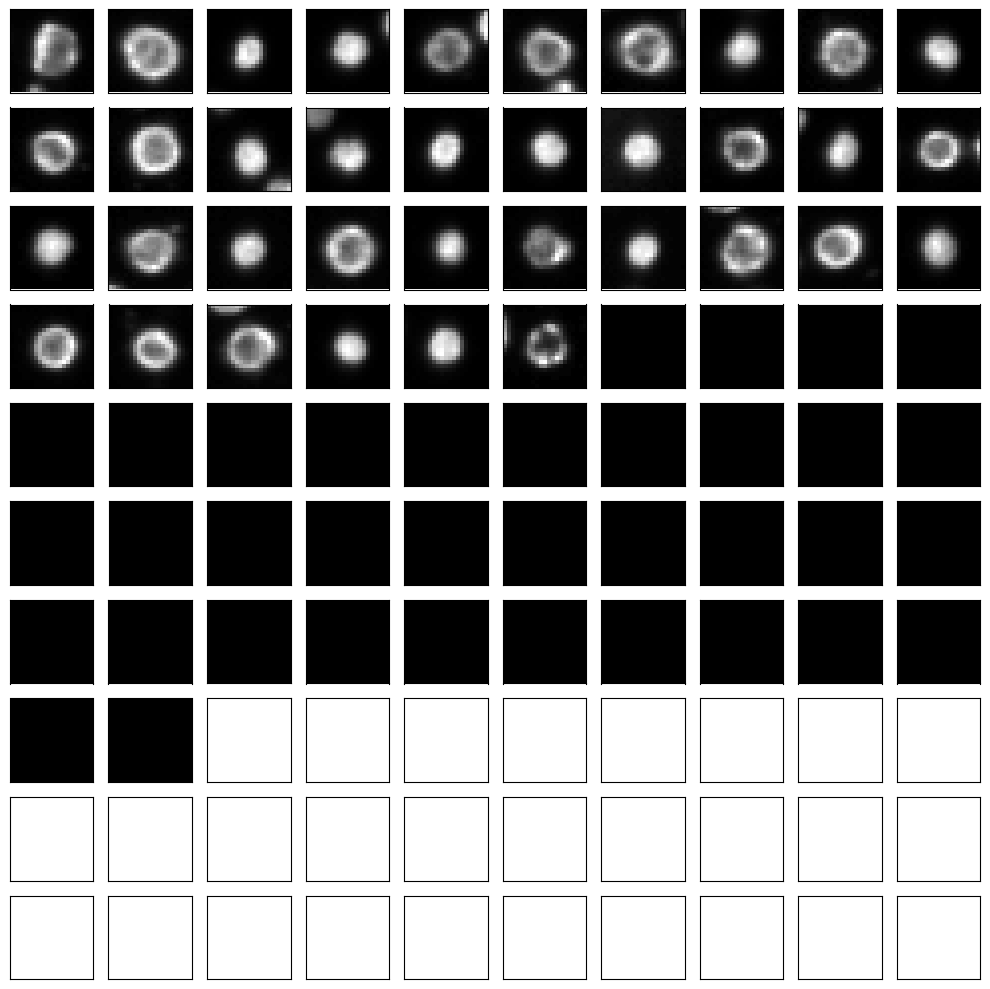

In [33]:
print(test_image.shape)  # Print the shape to understand the dimensionality

t_index = np.where(test_target == 0)[0]
visualize_image_gallery(test_image[t_index, :, :], 10, 10)  # Adjusted indexing

b_index = np.where(test_target == 1)[0]
visualize_image_gallery(test_image[b_index, :, :], 10, 10)  # Adjusted indexing

nk_index = np.where(test_target == 2)[0]
visualize_image_gallery(test_image[nk_index, :, :], 10, 10)  # Adjusted indexing

In [35]:
torch.save(model.state_dict(), '0ADD710_gated_full_lymph.pth')

In [ ]:
# comments
# class HDF5Dataset(Dataset):
#     def __init__(self, file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform
        
#         # Open the HDF5 file
#         with h5py.File(file_path, 'r') as file:
#             self.images = file['images'][:]
            
#         self.images = self.images[:, 1:, 1:, :] / 65535.0
#         self.targets = pd.read_hdf(file_path, key='features',
#                                    mode='r')['target'].values

#         # Get the number of samples in the dataset
#         self.num_samples = len(self.targets)

#     def __getitem__(self, index):
#         # Get the image and target from the HDF5 file
#         image = self.images[index]
#         target = self.targets[index]

#         # Convert the image and target to PyTorch tensors
#         image = torch.from_numpy(image).float()
#         target = torch.from_numpy(target).float()

#         # Apply any data augmentations or transformations
#         if self.transform is not None:
#             image = self.transform(image)

#         return image, target

#     def __len__(self):
#         return self.num_samples